# CISC 351 Project Milestone

## Identifying Hate Speech in Tweets
### Group 21
### Connor Crowe (20009994)
### Iain Doran-Des Brisay (20026553)
### Jordan Mack (20005220)
### March 9th 2020


Packages needed: seaborn, matplotlib, scipy, pandas, numpy, scikit-learn

In [1]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model, svm
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, RepeatedKFold
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, classification_report
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
import statistics

Reading dataset from local system:

In [2]:
df = pd.read_csv("hate_speech_dataset.csv")

Here we (will eventually) manipulate the columns from their original confidence score to our own normalized values. 

0 - 0.33    - Does not contain any hate speech but may contain offensive language

0.33 - 0.66 - May contain offensive language or hate speech

0.66 - 1    - Contains offensive language and may contain hate speech

Although these values are not discrete in our dataset due to confidence values given by the creators of this dataset.


In [3]:
# Delete columns:
dropColumns = [
    "_unit_id",
    "does_this_tweet_contain_hate_speech:confidence",
    "_golden",
    "_unit_state",
    "_trusted_judgments",
    "_last_judgment_at",
    "_created_at",
    "orig__golden",
    "orig__last_judgment_at",
    "orig__trusted_judgments",
    "orig__unit_id",
    "orig__unit_state",
    "_updated_at",
    "orig_does_this_tweet_contain_hate_speech",
    "does_this_tweet_contain_hate_speech_gold",
    "does_this_tweet_contain_hate_speech_gold_reason",
    "does_this_tweet_contain_hate_speechconfidence",
    "tweet_id"
]
df.drop(dropColumns, axis=1, inplace=True)

Hate Speech:		2399 (16.5%)
Offensive Language:	4836 (33.3%)
Non-offensive Speech:	7274 (50.1%)
Lenght of dataset:	14509


,type,tweet_text,label
0,Offensive,Warning: penny boards will make you a faggot,1
1,Hate,Fuck dykes,2
2,Hate,=@sizzurp__ @ILIKECATS74 @yoPapi_chulo @brando...,2
3,Hate,"""@jayswaggkillah: ""@JacklynAnnn: @jayswaggkill...",2
4,Offensive,@Zhugstubble You heard me bitch but any way I'...,1
...,...,...,...
14504,Neutral,I'm sorry. Did I offend your white supremacist...,0
14505,Neutral,@tradethecycles Caucasian euro aryan whatever....,0
14506,Neutral,=@yadavakhilesh sir a patient named Aryan Khan...,0
14507,Neutral,@Iamshivachari Happy birthday bro _Ì«ÌÐ_ \nHa...,0


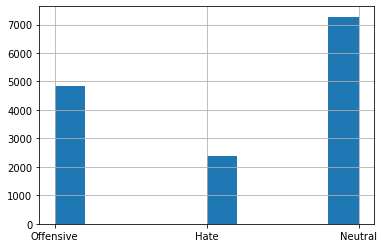

In [4]:
# change type data from:
# "The tweet contains hate speech" -> 1
# "The tweet uses offensive language but not hate speech" -> 2
# "The tweet is not offensive" -> 3
# Manipulate columns:
df = df.rename(columns={'does_this_tweet_contain_hate_speech': 'type'})

for i in range(len(df["type"])):
    if(df["type"][i] == "The tweet contains hate speech"):
        df["type"][i] = "Hate"
    elif(df["type"][i] == "The tweet uses offensive language but not hate speech"):
        df["type"][i] = "Offensive"
    elif(df["type"][i] == "The tweet is not offensive"):
        df["type"][i] = "Neutral"

df['label'] = df['type'].apply(lambda x: 0 if x=='Neutral' else (1 if x == 'Offensive' else 2))
df['type'].hist()
datasetLength = len(df)
lenHate = sum(1 for i in df["type"] if i == "Hate")
lenOffensive = sum(1 for i in df["type"] if i == "Offensive")
lenNeutral = sum(1 for i in df["type"] if i == "Neutral")

print("Hate Speech:\t\t"+str(lenHate)+" ("+str(round((lenHate/datasetLength)*100,1))+"%)")
print("Offensive Language:\t"+str(lenOffensive)+" ("+str(round((lenOffensive/datasetLength)*100,1))+"%)")
print("Non-offensive Speech:\t"+str(lenNeutral)+" ("+str(round((lenNeutral/datasetLength)*100,1))+"%)")
print("Lenght of dataset:\t"+str(datasetLength))
        
df

The next step is to divide the dataset into a training and test. In our model we will use train test split of 80/20, given that our dataset is 14.5k rows (fairly large), this may be changed later when execution can afford to be longer.

Also the use of a word count vecotrizer will be needed as this is a classification problem.

In [5]:
#X_train, X_test, y_train, y_test = train_test_split(df["tweet_text"], df["label"], test_size = 0.2, random_state=1)

# Naive Bayes (Optimal Parameters)
nb = MultinomialNB(alpha=1, fit_prior=True, class_prior=None)

# Random Forest (Optimal Parameters)
rf = RandomForestClassifier(n_estimators=100, random_state=0)

# Support Vector Machine (Optimal Parameters)
SVM = svm.SVC(C=10, kernel='rbf', gamma=0.001)

In [6]:
X = df["tweet_text"]
y = df["type"]

folds = 10

skf = StratifiedKFold(n_splits=folds, random_state=None)
index_iterator = skf.split(X, y)

kf = RepeatedKFold(n_splits=20, n_repeats=10, random_state=None)
scores = {
    "NaiveBayes":{
        "Accuracy": [],
        "Precision": [],
        "Recall": []
    },
    "RandomForest":{
        "Accuracy": [],
        "Precision": [],
        "Recall": []
    },
    "SVM":{
        "Accuracy": [],
        "Precision": [],
        "Recall": []
    }
}

nb_params = {
    "alpha": (1, 0.9, 0.7, 0.5, 0.3, 0.1, 0.01, 0.001, 0.0001, 0.00001),
    "fit_prior": (True, False),
    "class_prior": [None]
}

# Only kept the best parameters, grid search slows down execution time
svm_params = {
    'C': [10],
    'gamma': [1, 0.001],
    'kernel': ['rbf']
}


for i, (train_index, test_index) in enumerate(index_iterator):
    print('[Fold %d/%d]' % (i +1, folds))
    X_train, X_test = X[train_index], X[test_index] 
    y_train, y_test = y[train_index], y[test_index]
    cv = CountVectorizer(strip_accents='ascii', token_pattern=u'(?ui)\\bw*[a-z]+\\w*\\b', lowercase=True, stop_words="english")
    X_train_cv = cv.fit_transform(X_train)
    X_test_cv = cv.transform(X_test)
    
    # Naive Bayes (GridSearch Implementation)
#     nb_gs = GridSearchCV(estimator=nb, param_grid=nb_params)
#     nb_gs.fit(X_train_cv, y_train)
#     print(nb_gs.best_params_)
#     nb_pred = nb_gs.predict(X_test_cv)

    # Naive Bayes (Optimal Parameters)
    nb.fit(X_train_cv, y_train)
    nb_pred = nb.predict(X_test_cv)
    
    scores["NaiveBayes"]["Accuracy"].append(round(accuracy_score(y_test, nb_pred)*100,3))
    scores["NaiveBayes"]["Precision"].append(round(precision_score(y_test, nb_pred, average='micro')*100,3))
    scores["NaiveBayes"]["Recall"].append(round(recall_score(y_test, nb_pred, average='micro')*100,3))
    
    # Random Forest
#     rf.fit(X_train_cv, y_train) 
#     rf_pred = rf.predict(X_test_cv)
    
#     scores["RandomForest"]["Accuracy"].append(round(accuracy_score(y_test, rf_pred)*100,3))
#     scores["RandomForest"]["Precision"].append(round(precision_score(y_test, rf_pred, average='micro')*100,3))
#     scores["RandomForest"]["Recall"].append(round(recall_score(y_test, rf_pred, average='micro')*100,3))
    
#     # Support Vector Machine (GridSearch Implementation)
#     svm_gs = GridSearchCV(estimator=SVM, param_grid=svm_params)
#     svm_gs.fit(X_train_cv, y_train)
#     print(svm_gs.best_params_)
#     svm_pred = svm_gs.predict(X_test_cv)

    # Support Vector Machine (Optimal Parameters)
#     SVM.fit(X_train_cv, y_train)
#     svm_pred = SVM.predict(X_test_cv)
    
#     scores["SVM"]["Accuracy"].append(round(accuracy_score(y_test, svm_pred)*100,3))
#     scores["SVM"]["Precision"].append(round(precision_score(y_test, svm_pred, average='micro')*100,3))
#     scores["SVM"]["Recall"].append(round(recall_score(y_test, svm_pred, average='micro')*100,3))


[Fold 1/10]
[Fold 2/10]
[Fold 3/10]
[Fold 4/10]
[Fold 5/10]
[Fold 6/10]
[Fold 7/10]
[Fold 8/10]
[Fold 9/10]
[Fold 10/10]


Check the accuracy of our Naive Bayes Classifier:

In [7]:
print("NAIVE BAYES")
for i in range(len(scores["NaiveBayes"]["Accuracy"])):
    print("[Fold "+str(i+1)+"]")
    print("Accuracy:\t"+str(scores["NaiveBayes"]["Accuracy"][i]))
    print("Precision:\t"+str(scores["NaiveBayes"]["Precision"][i]))
    print("Recall:\t\t"+str(scores["NaiveBayes"]["Recall"][i])+"\n")
print("Avg. Accuracy: "+str(round(statistics.mean(scores["NaiveBayes"]["Accuracy"]),2))+"%\n")
    
# print("RANDOM FOREST")
# for i in range(len(scores["RandomForest"]["Accuracy"])):
#     print("[Fold "+str(i+1)+"]")
#     print("Accuracy:\t"+str(scores["RandomForest"]["Accuracy"][i])+"%")
#     print("Precision:\t"+str(scores["RandomForest"]["Precision"][i])+"%")
#     print("Recall:\t\t"+str(scores["RandomForest"]["Recall"][i])+"%\n")
# print("Avg. Accuracy: "+str(round(statistics.mean(scores["RandomForest"]["Accuracy"]),2))+"%")
# print("Avg. Precision: "+str(round(statistics.mean(scores["RandomForest"]["Precision"]),2))+"%")
# print("Avg. Recall: "+str(round(statistics.mean(scores["RandomForest"]["Recall"]),2))+"%\n")
    
# print("SUPPORT VECTOR MACHINE")
# for i in range(len(scores["SVM"]["Accuracy"])):
#     print("[Fold "+str(i+1)+"]")
#     print("Accuracy:\t"+str(scores["SVM"]["Accuracy"][i])+"%")
#     print("Precision:\t"+str(scores["SVM"]["Precision"][i])+"%")
#     print("Recall:\t\t"+str(scores["SVM"]["Recall"][i])+"%\n")
# print("Avg. Accuracy: "+str(round(statistics.mean(scores["SVM"]["Accuracy"]),2))+"%\n")

NAIVE BAYES
[Fold 1]
Accuracy:	64.669
Precision:	64.669
Recall:		64.669

[Fold 2]
Accuracy:	63.567
Precision:	63.567
Recall:		63.567

[Fold 3]
Accuracy:	75.826
Precision:	75.826
Recall:		75.826

[Fold 4]
Accuracy:	67.7
Precision:	67.7
Recall:		67.7

[Fold 5]
Accuracy:	64.094
Precision:	64.094
Recall:		64.094

[Fold 6]
Accuracy:	72.433
Precision:	72.433
Recall:		72.433

[Fold 7]
Accuracy:	70.069
Precision:	70.069
Recall:		70.069

[Fold 8]
Accuracy:	77.172
Precision:	77.172
Recall:		77.172

[Fold 9]
Accuracy:	76.0
Precision:	76.0
Recall:		76.0

[Fold 10]
Accuracy:	70.462
Precision:	70.462
Recall:		70.462

Avg. Accuracy: 70.2%



Judging from the prediction scores labelled above (~70%), this model performs relatively well given how little "hate speech" classified data is in our set. When eliminating the "Offensive" label to "Neutral" we see a jump in prediction accuracy to 83%

Text(33.0, 0.5, 'Predicted')

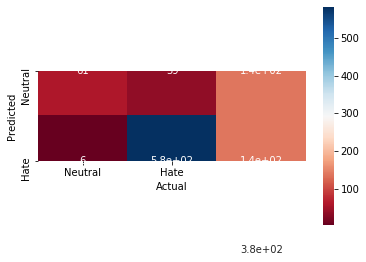

In [8]:
# matrix = confusion_matrix(y_test, nb_pred)
# sns.heatmap(matrix, square=True, annot=True, cmap='RdBu', cbar=False,
# xticklabels=['Neutral','Offensive','Hate'], yticklabels=['Neutral','Offensive','Hate'])
# plt.xlabel('Actual')
# plt.ylabel('Predicted')

matrix = confusion_matrix(y_test, nb_pred)
sns.heatmap(matrix, square=True, annot=True, cmap='RdBu', cbar=True,
xticklabels=['Neutral','Hate'], yticklabels=['Neutral','Hate'])
plt.xlabel('Actual')
plt.ylabel('Predicted')

In [18]:
%pwd

'C:\\Users\\jorda\\AppData\\Roaming\\SPB_Data'

### Random Forest

In [9]:
# rf_matrix = confusion_matrix(y_test, rf_pred)
# print(classification_report(y_test, rf_pred))
# print(accuracy_score(y_test, rf_pred))
# sns.heatmap(rf_matrix, square=True, annot=True, cmap='RdBu', cbar=False,
# xticklabels=['Neutral','Offensive','Hate'], yticklabels=['Neutral','Offensive','Hate'])
# plt.xlabel('Actual')
# plt.ylabel('Predicted')

rf_matrix = confusion_matrix(y_test, rf_pred)
print(classification_report(y_test, rf_pred))
print(accuracy_score(y_test, rf_pred))
sns.heatmap(rf_matrix, square=True, annot=True, cmap='RdBu', cbar=False,
xticklabels=['Neutral','Hate'], yticklabels=['Neutral','Hate'])
plt.xlabel('Actual')
plt.ylabel('Predicted')

NameError: name 'rf_pred' is not defined

### Support Vector Machine

In [ ]:
# svm_matrix = confusion_matrix(y_test,svm_pred)
# print(classification_report(y_test,svm_pred))
# print(accuracy_score(y_test, svm_pred))
# sns.heatmap(svm_matrix, square=True, annot=True, cmap='RdBu', cbar=False,
# xticklabels=['Neutral','Offensive','Hate'], yticklabels=['Neutral','Offensive','Hate'])
# plt.xlabel('Actual')
# plt.ylabel('Predicted')

svm_matrix = confusion_matrix(y_test,svm_pred)
print(classification_report(y_test,svm_pred))
print(accuracy_score(y_test, svm_pred))
sns.heatmap(svm_matrix, square=True, annot=True, cmap='RdBu', cbar=False,
xticklabels=['Neutral','Hate'], yticklabels=['Neutral','Hate'])
plt.xlabel('Actual')
plt.ylabel('Predicted')